In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 325 ms (started: 2023-03-21 17:01:48 -07:00)


# Media Bias

Samantha D'Alonzo and Max Tegmark (yes, the cosmologist) looked at characterizing various publications by counts of certain phrases and then applied a generalized PCA to get a 2D layout that creditably distributed both left-right and establishment bias. The paper is available at [PLOS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0271947) (and [arxiv](https://arxiv.org/abs/2109.00024)) and the phrase counts are at [kaggle](https://www.kaggle.com/datasets/tegmark/mediabias) and [Max Tegmark's own webpage](https://space.mit.edu/home/tegmark/phrasebias.html).

The phrase counts are divided into different CSV files with different subjects, which incidentally make for a great list of things to *not* discuss with your relatives at any family gathering:

In [2]:
# note that the "police" subject has an extra trailing underscore
subjects = [
    "abortion",
    "affirmative_action",
    "blm_movement",
    "china",
    "church_state",
    "climate_change",
    "cuba",
    "espionage",
    "guns",
    "human_rights",
    "islam",
    "israel",
    "judaism",
    "military_spending",
    "native_americans",
    "nuclear_weapons",
    "oil",
    "palestine",
    "police_",
    "prisons",
    "private_finance",
    "public_finance",
    "russia",
    "sexual_harrassment",
    "tech_censorship",
    "universities",
    "us_immigration",
    "venezuela",
    "yemen",
]

time: 4.91 ms (started: 2023-03-21 17:01:48 -07:00)


Below is some code to download the tar file from Max Tegmark's webpage. Note that I got an issue with the MIT web site not having the latest SSL ciphers, so you may need to uncomment the line about `DEFAULT_CIPHERS`.

In [3]:
import tarfile
from io import BytesIO

import requests

# Uncomment if you get a SSLError with a DH_KEY_TOO_SMALL message
# https://stackoverflow.com/a/75048832/4096483
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += "@SECLEVEL=1"

dfs = []

url = "https://space.mit.edu/home/tegmark/phrasebias_data.tar.gz"
req = requests.get(url, timeout=10)
with tarfile.open(fileobj=BytesIO(req.content), mode="r") as tar_obj:
    for subject in subjects:
        fileobj = tar_obj.extractfile(
            f"phrasebias_data/phrase_counts/{subject}_counts.csv"
        )
        dfs.append(pd.read_csv(fileobj))
        fileobj.close()

df = pd.concat(dfs, sort=True)
df

,PHRASE,TOTAL,aljazeera,alternet,americanconservative,americanspectator,americanthinker,antiwar,ap,atlantic,...,truthdig,usatoday,verge,veteranstoday,vice,voltairenetwork,vox,wapo,wired,wsj
0,pro life,4849,12,13,68.0,10.0,NaN,NaN,7,16,...,5.0,131,NaN,NaN,13.0,NaN,60,242,NaN,1.0
1,abortion rights,4851,97,42,15.0,5.0,NaN,NaN,43,63,...,32.0,211,NaN,NaN,103.0,NaN,461,585,NaN,24.0
2,anti abortion,4067,53,54,4.0,0.0,NaN,NaN,37,49,...,27.0,239,NaN,NaN,143.0,NaN,487,29,NaN,3.0
3,anti choice,705,0,54,0.0,0.0,NaN,NaN,0,1,...,5.0,5,NaN,NaN,38.0,NaN,14,19,NaN,0.0
4,abortion care,1215,7,13,0.0,1.0,NaN,NaN,2,2,...,7.0,52,NaN,NaN,60.0,NaN,76,64,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,the IRGC,346,21,1,21.0,NaN,NaN,0.0,0,2,...,9.0,1,NaN,0.0,0.0,NaN,19,31,NaN,14.0
25,the JCPOA,725,27,10,49.0,NaN,NaN,6.0,3,12,...,35.0,8,NaN,2.0,0.0,NaN,1,33,NaN,2.0
26,the Yemeni,1372,238,4,31.0,NaN,NaN,15.0,2,8,...,17.0,7,NaN,14.0,2.0,NaN,13,86,NaN,3.0
27,war on Yemen,678,5,12,252.0,NaN,NaN,36.0,0,1,...,20.0,0,NaN,2.0,0.0,NaN,7,4,NaN,0.0


time: 2.1 s (started: 2023-03-21 17:01:48 -07:00)


Now to do some clean-up:

1. The `NaN`s in the data are because some publications aren't included in the different subject analyses. In that case, I am going to set those values to 0.
1. The dataframe also has the phrases as rows and the publications as columns. I want the publication as a row and the phrase counts as columns, so we will tranpose the data.
1. The phrase itself (in the `PHRASE` column) should be the index.
1. I don't need the `TOTAL` (which won't make sense after transposing).

In [4]:
df = df.fillna(0.0).set_index("PHRASE").iloc[:, 1:].transpose()

time: 22.1 ms (started: 2023-03-21 17:01:50 -07:00)


Finally, after transposing the `PHRASE` is now the name of the columns, rather than the name of the index, which should be `publication` now anyway. I am sure there is a better way to do this, but this works:

In [5]:
df.columns.name = None
df.index.rename("publication", inplace=True)

time: 7.06 ms (started: 2023-03-21 17:01:51 -07:00)


In [6]:
df

,pro life,abortion rights,anti abortion,anti choice,abortion care,pregnancy,kill,medical abortion,family planning,pro abortion,...,Saudi led coalition,separatists,Special Operations,terrorist,the Houthis,the IRGC,the JCPOA,the Yemeni,war on Yemen,terrorism
publication,,,,,,,,,,,,,,,,,,,,,
aljazeera,12.0,97.0,53.0,0.0,7.0,61.0,2.0,2.0,18.0,6.0,...,261.0,172.0,0.0,143.0,832.0,21.0,27.0,238.0,5.0,169.0
alternet,13.0,42.0,54.0,54.0,13.0,69.0,5.0,0.0,15.0,1.0,...,6.0,0.0,24.0,28.0,11.0,1.0,10.0,4.0,12.0,30.0
americanconservative,68.0,15.0,4.0,0.0,0.0,8.0,1.0,0.0,0.0,3.0,...,44.0,14.0,5.0,82.0,121.0,21.0,49.0,31.0,252.0,89.0
americanspectator,10.0,5.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
americanthinker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
voltairenetwork,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vox,60.0,461.0,487.0,14.0,76.0,487.0,29.0,8.0,72.0,29.0,...,25.0,3.0,0.0,87.0,15.0,19.0,1.0,13.0,7.0,62.0
wapo,242.0,585.0,29.0,19.0,64.0,531.0,14.0,9.0,130.0,28.0,...,194.0,34.0,30.0,334.0,347.0,31.0,33.0,86.0,4.0,322.0


time: 86.1 ms (started: 2023-03-21 17:01:51 -07:00)


Here are all the sampled publications:

In [7]:
df.index

Index(['aljazeera', 'alternet', 'americanconservative', 'americanspectator',
       'americanthinker', 'antiwar', 'ap', 'atlantic', 'axios', 'bbc',
       'bloomberg', 'breitbart', 'businessinsider', 'buzzfeed', 'canary',
       'cbs', 'cnbc', 'cnn', 'commondreams', 'consortium', 'conversation',
       'counterpunch', 'dailycaller', 'dailykos', 'dailymail', 'dailywire',
       'defenseone', 'economist', 'eff', 'factcheck', 'federalist',
       'fivethirtyeight', 'foreignaffairs', 'fox', 'freebeacon',
       'globalresearch', 'grayzone', 'guardian', 'huffingtonpost',
       'independent', 'infowars', 'intercept', 'jacobinmag', 'jpost',
       'koreaherald', 'lewrockwell', 'mintpress', 'motherjones', 'msnbc',
       'nationalreview', 'nbc', 'neweasternoutlook', 'newsbud', 'newyorker',
       'npr', 'nypost', 'nytimes', 'observerny', 'offguardian', 'opednews',
       'pbs', 'peoplesdaily', 'pjmedia', 'propublica', 'psychologytoday',
       'rawstory', 'redstate', 'reuters', 'reveal', 'rt'

time: 5.74 ms (started: 2023-03-21 17:01:51 -07:00)


Compared to the paper, the following publications are in the dataset but don't appear in the generalized principle component plots there (Science and Defense One are mentioned as being included in a correlation analysis):

In [8]:
filtered_publications = [
    "bloomberg",
    "defenseone",
    "factcheck",
    "koreaherald",
    "msnbc",
    "newsbud",
    "science",
    "scientificamerican",
    "wired",
]

time: 5.19 ms (started: 2023-03-21 17:01:51 -07:00)


## Bias Values

The authors identify two sources of bias:

* left/right bias taken from <https://www.allsides.com/media-bias>.
* establishment stance (pro/critical) taken from <https://www.improvethenews.org/>, <https://swprs.org/media-navigator/> and Wikipedia.

In both cases they are classified into 5 levels. Unfortunately, these values aren't provided as downloadable data and attempting to recreate it from the sources above is difficult because:

* Not all sources are in either the allsides or media navigator database.
* The media navigator uses a three-point scale (close, intermediate, distant) for establishment bias.
* Improve the News does have a five-point scale, but to get a particular media source to show up, you have to look for specific stories and then hope that publication is in the list, so it's very time-consuming.

Instead I have done my best to recreate the values using the media legend of Figure 2 of the paper, which uses color for the left/right bias, and size for the establishment bias. The latter was substantially harder to do than I thought: distinguishing between the smallest two sizes and then within the larger three sizes was not always easy. So expect some mistakes. Also, publications not used in Figure 2 are removed.

In [9]:
filtered_df = df.loc[~df.index.isin(filtered_publications), :]
filtered_df

,pro life,abortion rights,anti abortion,anti choice,abortion care,pregnancy,kill,medical abortion,family planning,pro abortion,...,Saudi led coalition,separatists,Special Operations,terrorist,the Houthis,the IRGC,the JCPOA,the Yemeni,war on Yemen,terrorism
publication,,,,,,,,,,,,,,,,,,,,,
aljazeera,12.0,97.0,53.0,0.0,7.0,61.0,2.0,2.0,18.0,6.0,...,261.0,172.0,0.0,143.0,832.0,21.0,27.0,238.0,5.0,169.0
alternet,13.0,42.0,54.0,54.0,13.0,69.0,5.0,0.0,15.0,1.0,...,6.0,0.0,24.0,28.0,11.0,1.0,10.0,4.0,12.0,30.0
americanconservative,68.0,15.0,4.0,0.0,0.0,8.0,1.0,0.0,0.0,3.0,...,44.0,14.0,5.0,82.0,121.0,21.0,49.0,31.0,252.0,89.0
americanspectator,10.0,5.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
americanthinker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vice,13.0,103.0,143.0,38.0,60.0,262.0,6.0,2.0,12.0,3.0,...,6.0,0.0,0.0,3.0,3.0,0.0,0.0,2.0,0.0,3.0
voltairenetwork,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vox,60.0,461.0,487.0,14.0,76.0,487.0,29.0,8.0,72.0,29.0,...,25.0,3.0,0.0,87.0,15.0,19.0,1.0,13.0,7.0,62.0


time: 38.9 ms (started: 2023-03-21 17:01:51 -07:00)


In [10]:
political_code = [
    1,
    0,
    3,
    4,
    4,
    4,
    2,
    1,
    2,
    2,
    4,
    2,
    0,
    0,
    1,
    2,
    1,
    0,
    2,
    1,
    0,
    4,
    0,
    4,
    4,
    1,
    2,
    4,
    2,
    2,
    3,
    4,
    2,
    0,
    1,
    0,
    1,
    4,
    0,
    0,
    2,
    4,
    0,
    0,
    4,
    1,
    4,
    1,
    2,
    4,
    0,
    2,
    0,
    1,
    2,
    0,
    3,
    1,
    2,
    0,
    4,
    2,
    0,
    2,
    0,
    0,
    2,
    0,
    0,
    4,
    4,
    2,
    1,
    4,
    0,
    2,
    1,
    4,
    0,
    2,
    0,
    1,
    2,
]

time: 9.2 ms (started: 2023-03-21 17:01:51 -07:00)


In [11]:
establishment_code = [
    1,
    1,
    1,
    4,
    4,
    0,
    4,
    3,
    3,
    4,
    2,
    3,
    4,
    0,
    4,
    4,
    4,
    1,
    0,
    2,
    1,
    3,
    1,
    4,
    2,
    4,
    1,
    3,
    3,
    4,
    3,
    4,
    0,
    1,
    4,
    3,
    2,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    4,
    3,
    1,
    1,
    4,
    4,
    4,
    1,
    0,
    1,
    4,
    0,
    3,
    2,
    3,
    0,
    3,
    4,
    1,
    0,
    1,
    3,
    3,
    1,
    1,
    4,
    1,
    1,
    4,
    2,
    1,
    4,
    2,
    1,
    4,
    0,
    2,
    4,
    4,
]

time: 10.8 ms (started: 2023-03-21 17:01:51 -07:00)


In [12]:
political_bias_categories = np.array(
    ["left", "lean left", "center", "lean right", "right"]
)
political_bias = political_bias_categories[political_code]
political_bias

array(['lean left', 'left', 'lean right', 'right', 'right', 'right',
       'center', 'lean left', 'center', 'center', 'right', 'center',
       'left', 'left', 'lean left', 'center', 'lean left', 'left',
       'center', 'lean left', 'left', 'right', 'left', 'right', 'right',
       'lean left', 'center', 'right', 'center', 'center', 'lean right',
       'right', 'center', 'left', 'lean left', 'left', 'lean left',
       'right', 'left', 'left', 'center', 'right', 'left', 'left',
       'right', 'lean left', 'right', 'lean left', 'center', 'right',
       'left', 'center', 'left', 'lean left', 'center', 'left',
       'lean right', 'lean left', 'center', 'left', 'right', 'center',
       'left', 'center', 'left', 'left', 'center', 'left', 'left',
       'right', 'right', 'center', 'lean left', 'right', 'left', 'center',
       'lean left', 'right', 'left', 'center', 'left', 'lean left',
       'center'], dtype='<U10')

time: 9.24 ms (started: 2023-03-21 17:01:51 -07:00)


In [13]:
establishment_bias_categories = np.array(
    ["critical", "slightly critical", "neutral", "slightly pro", "pro"]
)
establishment_bias = establishment_bias_categories[establishment_code]
establishment_bias

array(['slightly critical', 'slightly critical', 'slightly critical',
       'pro', 'pro', 'critical', 'pro', 'slightly pro', 'slightly pro',
       'pro', 'neutral', 'slightly pro', 'pro', 'critical', 'pro', 'pro',
       'pro', 'slightly critical', 'critical', 'neutral',
       'slightly critical', 'slightly pro', 'slightly critical', 'pro',
       'neutral', 'pro', 'slightly critical', 'slightly pro',
       'slightly pro', 'pro', 'slightly pro', 'pro', 'critical',
       'slightly critical', 'pro', 'slightly pro', 'neutral',
       'slightly critical', 'slightly critical', 'slightly critical',
       'critical', 'slightly critical', 'slightly critical',
       'slightly critical', 'pro', 'slightly pro', 'slightly critical',
       'slightly critical', 'pro', 'pro', 'pro', 'slightly critical',
       'critical', 'slightly critical', 'pro', 'critical', 'slightly pro',
       'neutral', 'slightly pro', 'critical', 'slightly pro', 'pro',
       'slightly critical', 'critical', 'slightl

time: 4.48 ms (started: 2023-03-21 17:01:51 -07:00)


In [14]:
target = pd.DataFrame(
    dict(
        establishment_bias=pd.Categorical(
            establishment_bias, categories=establishment_bias_categories
        ),
        political_bias=pd.Categorical(
            political_bias, categories=political_bias_categories
        ),
    )
)
target.index = filtered_df.index
target

,establishment_bias,political_bias
publication,,
aljazeera,slightly critical,lean left
alternet,slightly critical,left
americanconservative,slightly critical,lean right
americanspectator,pro,right
americanthinker,pro,right
...,...,...
vice,pro,left
voltairenetwork,critical,center
vox,neutral,left


time: 17.8 ms (started: 2023-03-21 17:01:51 -07:00)


Let's create a palette for the political and establishment bias. I will use 5-color palettes from [ColorBrewer](https://colorbrewer2.org/). Although outside of the USA it doesn't make a ton of sense for left-wing to be blue and right-wing to be red, to avoid being confusing compared to the paper, I will stick with that color scheme for the political leaning. For establishment bias I will use the purple-to-green palette going from critical to pro (with no meaning to those colors beyond trying not to be too reminiscient of red to blue).

In [15]:
# The rdbu5 palette goes from red-to-blue, so we need to reverse it for the left-to-right categories
rdbu5 = ["#ca0020", "#f4a582", "#f7f7f7", "#92c5de", "#0571b0"]
rdbu5.reverse()
prgn5 = ["#7b3294", "#c2a5cf", "#f7f7f7", "#a6dba0", "#008837"]

media_bias_palette = dict(
    establishment_bias=dict(zip(establishment_bias_categories, prgn5)),
    political_bias=dict(zip(political_bias_categories, rdbu5)),
)

time: 3.6 ms (started: 2023-03-21 17:01:51 -07:00)


## UMAP result

Here's an example of running UMAP on the data. Rather than use the raw counts, I'll use the [sklearn RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) to give each phrase roughly equal importance. I'm not saying this is a great idea.

In [42]:
from drnb.embed.umap.umap import Umap
from sklearn.preprocessing import RobustScaler

coords = Umap(params=dict(n_neighbors=5)).embed(
    RobustScaler().fit_transform(filtered_df.to_numpy())
)

[18:01:53] INFO     Running UMAP                                                                        ]8;id=38026;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=813974;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#162\162]8;;\

[18:01:56] INFO     Embedding completed                                                                 ]8;id=586983;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py\umap.py]8;;\:]8;id=675743;file:///home/james/dev/drnb/src/drnb/embed/umap/umap.py#167\167]8;;\

time: 2.94 s (started: 2023-03-21 18:01:53 -07:00)


And let's put some data together to give a bubble plot display a bit like what's in the paper.

In [124]:
result_df = pd.DataFrame(
    dict(
        x=coords[:, 0],
        y=coords[:, 1],
        publication=filtered_df.index,
        establishment_bias=target.establishment_bias.cat.as_ordered(),
        political_bias=target.political_bias.cat.as_ordered(),
    )
)


time: 3.6 ms (started: 2023-03-21 19:14:39 -07:00)


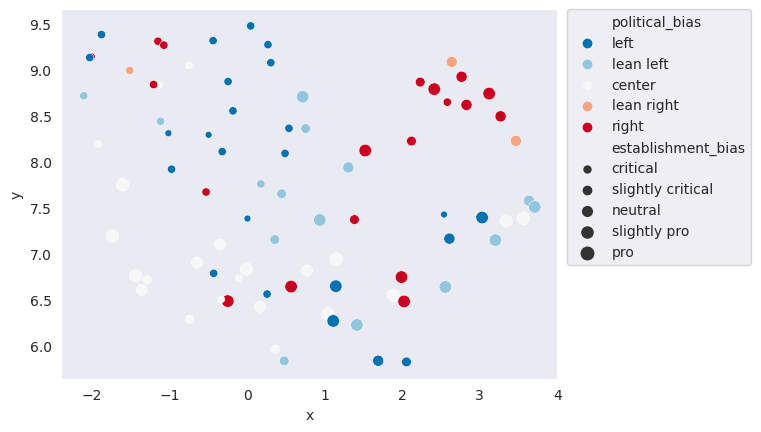

time: 465 ms (started: 2023-03-21 19:17:30 -07:00)


In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("dark")
sns.scatterplot(
    data=result_df,
    x="x",
    y="y",
    hue="political_bias",
    size="establishment_bias",
    palette=rdbu5,
    sizes=[(x + 5) ** 2 for x in range(0, 5)],
)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

The layout isn't horrible, but I am sure some better scaling would give nicer results. Also, to see the actual names of the publication we should use something like plotly to put it in the tooltip. While plotly can do bubbleplots, mapping categorical values to sizes through the `express` API is a real pain.

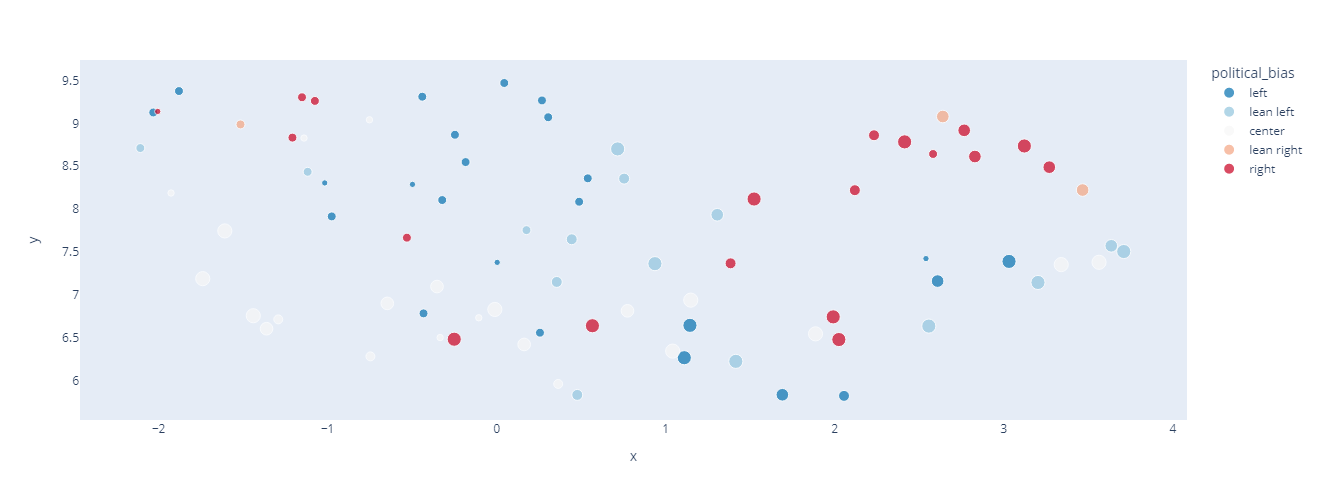

time: 67.8 ms (started: 2023-03-21 19:50:28 -07:00)


In [180]:
import plotly.express as px

result_df["establishment_code"] = (
    result_df["establishment_bias"].cat.as_ordered().cat.codes.values + 1
)

fig = px.scatter(
    result_df,
    x="x",
    y="y",
    color="political_bias",
    size="establishment_code",
    hover_data=["publication"],
    color_discrete_map=media_bias_palette["political_bias"],
    width=700,
    height=500,
    size_max=10,
    category_orders={"political_bias": political_bias_categories},
)
fig.update_xaxes(showgrid=False, zeroline=False).update_yaxes(showgrid=False)

## Pipeline

This isn't very good right now as I don't think the scaling has been handled correctly

In [ ]:
from drnb.io.pipeline import create_default_pipeline

_ = create_default_pipeline(check_for_duplicates=True, scale="z").run(
    "mediabias",
    data=filtered_df,
    target=target,
    target_palette=media_bias_palette,
    tags=["small"],
    url="https://doi.org/10.1371/journal.pone.0271947",
    verbose=True,
)

[17:25:37] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=709331;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=835078;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#560\560]8;;\

           INFO     Initial data shape: (83, 839)                                                    ]8;id=317061;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=318897;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#75\75]8;;\

           INFO     Keeping all columns                                                            ]8;id=494380;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=197050;file:///home/james/dev/drnb/src/drnb/preprocess.py#67\67]8;;\

           INFO     Data shape after filtering columns: (83, 839)                                   ]8;id=298255;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=712517;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=5568;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=132479;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#130\130]8;;\

           INFO     Data shape after filtering NAs: (83, 839)                                       ]8;id=533425;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=631563;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#141\141]8;;\

           INFO     Checked for duplicates: found 0                                                 ]8;id=768718;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=393706;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#153\153]8;;\

           INFO     Z-Scaling                                                                      ]8;id=326202;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=921984;file:///home/james/dev/drnb/src/drnb/preprocess.py#32\32]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=291386;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=883326;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     Writing data for mediabias                                                      ]8;id=858420;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=264545;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#226\226]8;;\

           INFO     Processing target with initial shape (83, 2)                                    ]8;id=735339;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=485575;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#197\197]8;;\

           INFO     Keeping all columns                                                            ]8;id=84992;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=410660;file:///home/james/dev/drnb/src/drnb/preprocess.py#67\67]8;;\

           INFO     Writing target for mediabias                                                    ]8;id=933672;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=51950;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#226\226]8;;\

           INFO     Writing pkl format to data/mediabias-target-palette.pkl                         ]8;id=362955;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=103237;file:///home/james/dev/drnb/src/drnb/io/__init__.py#265\265]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=206943;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=52499;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#241\241]8;;\

           WARNING  151 neighbors requested but only 83 items in the data                            ]8;id=743512;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=86394;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#68\68]8;;\

           INFO     Using 'faiss' to find nearest neighbors                                          ]8;id=818296;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=554979;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#81\81]8;;\

           INFO     Finding 83 neighbors using faiss with euclidean metric and params: {}            ]8;id=48722;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=959681;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#94\94]8;;\

[17:25:39] INFO     Writing numpy format to nn/mediabias.16.euclidean.exact.faiss.idx.npy           ]8;id=557055;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=868252;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing csv format to nn/mediabias.16.euclidean.exact.faiss.idx.csv             ]8;id=634895;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=554670;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to nn/mediabias.16.euclidean.exact.faiss.dist.npy          ]8;id=790687;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=471748;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing csv format to nn/mediabias.16.euclidean.exact.faiss.dist.csv            ]8;id=965995;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=221686;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to nn/mediabias.51.euclidean.exact.faiss.idx.npy           ]8;id=571349;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=120277;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing csv format to nn/mediabias.51.euclidean.exact.faiss.idx.csv             ]8;id=296863;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=607867;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to nn/mediabias.51.euclidean.exact.faiss.dist.npy          ]8;id=608389;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=883528;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing csv format to nn/mediabias.51.euclidean.exact.faiss.dist.csv            ]8;id=443416;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=174444;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to nn/mediabias.151.euclidean.exact.faiss.idx.npy          ]8;id=874328;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=970425;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing csv format to nn/mediabias.151.euclidean.exact.faiss.idx.csv            ]8;id=826078;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=37234;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to nn/mediabias.151.euclidean.exact.faiss.dist.npy         ]8;id=575054;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=830118;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing csv format to nn/mediabias.151.euclidean.exact.faiss.dist.csv           ]8;id=10936;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=92897;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Calculating triplets                                                            ]8;id=214929;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=945228;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#252\252]8;;\

           INFO     Writing csv format to triplets/mediabias.5.1337.idx.csv                         ]8;id=774394;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=365771;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing csv format to triplets/mediabias.5.1337.euclidean.csv                   ]8;id=263187;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=535484;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to triplets/mediabias.5.1337.idx.npy                       ]8;id=390506;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=881415;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing numpy format to triplets/mediabias.5.1337.euclidean.npy                 ]8;id=725119;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=834638;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing pipeline result for mediabias                                           ]8;id=579661;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=373935;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#123\123]8;;\

time: 2.14 s (started: 2023-03-21 17:25:37 -07:00)
